In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

In [60]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1.0)])


train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

print(f"No of training samples : {len(train_dataset)}")
print(f"No of test samples : {len(test_dataset)}")




No of training samples : 60000
No of test samples : 10000


torch.Size([512, 28, 28])
torch.Size([512, 28, 28])
torch.Size([512, 28, 28])


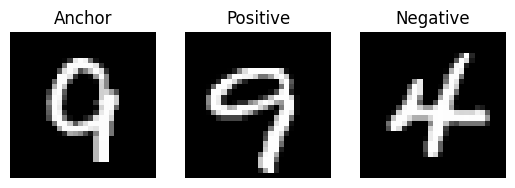

In [102]:
class TripletDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.data = dataset.data
        self.labels = dataset.targets

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        anchor = self.data[index]
        anchor_label = self.labels[index]

        # Sample a positive sample from the same class
        positive_idx = np.random.choice(np.where(self.labels == anchor_label)[0])
        while positive_idx == index:
            positive_idx = np.random.choice(np.where(self.labels == anchor_label)[0])
        positive = self.data[positive_idx]

        # Sample a negative sample from a different class
        negative_idx = np.random.choice(np.where(self.labels != anchor_label)[0])
        negative = self.data[negative_idx]

        return {
            'anchor': anchor,
            'positive': positive,
            'negative': negative
        }



batch_size = 512
train_triplet_dataset = TripletDataset(train_dataset)
train_loader = DataLoader(train_triplet_dataset, batch_size=batch_size, shuffle=True)

for batch in train_loader:
    anchors = batch['anchor']
    positives = batch['positive']
    negatives = batch['negative']
    print(anchors.shape)
    print(positives.shape)
    print(negatives.shape)
    fig, axes = plt.subplots(1, 3)  # Create a figure with 3 subplots

    # Display the anchor image
    axes[0].imshow(anchors[0].squeeze(), cmap='gray')
    axes[0].set_title('Anchor')
    axes[0].axis('off')  # Turn off axis labels

    # Display the positive image
    axes[1].imshow(positives[0].squeeze(), cmap='gray')
    axes[1].set_title('Positive')
    axes[1].axis('off')  # Turn off axis labels

    # Display the negative image
    axes[2].imshow(negatives[0].squeeze(), cmap='gray')
    axes[2].set_title('Negative')
    axes[2].axis('off')  # Turn off axis labels
    break

In [103]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()

        self.tripletmodel=nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),  # Input: 1x28x28, Output: 32x28x28
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),                 # Output: 32x14x14
            nn.Dropout(0.5),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Output: 64x14x14
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),                 # Output: 64x7x7
            nn.Dropout(0.5),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),# Output: 128x7x7
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),                 # Output: 128x3x3
            nn.Dropout(0.5),

            nn.Conv2d(128, 128, kernel_size=2, stride=1, padding=0), # Output: 128x2x2
            nn.ReLU(True),

            nn.Flatten(),
            nn.Linear(128 * 2 * 2, 128),
            nn.BatchNorm1d(128),
            nn.Tanh()

        )
    def forward(self, x):
      x = x.to(torch.float32)
      x = x.unsqueeze(1)
      return self.tripletmodel(x)



In [104]:

class Triplet_loss(nn.Module):
    def __init__(self):
        super(Triplet_loss, self).__init__()

    def forward(self, x, x_plus, x_minus):
        # Compute the distances between embeddings
        d_x_plus = torch.norm(x - x_plus, p=2,dim=1)
        d_x_minus = torch.norm(x - x_minus, p=2,dim=1)

        # Compute the softmax values
        d_plus = torch.exp(d_x_plus) / (torch.exp(d_x_plus) + torch.exp(d_x_minus))
        d_minus = torch.exp(d_x_minus) / (torch.exp(d_x_plus) + torch.exp(d_x_minus))

        # loss
        l = d_plus**2 + (d_minus - 1) ** 2

        return l.mean()


In [107]:
model=EmbeddingNet()
loss=Triplet_loss()
optimizer = optim.SGD(model.parameters(), lr=0.5, momentum=0.9)
epoch_losses = []
for epoch in range(2):
    batch_losses = []
    for batch_idx, batch in enumerate(train_loader):
        anchors = batch['anchor']
        positives = batch['positive']
        negatives = batch['negative']

        anchor_embeddings = model(anchors)

        positive_embeddings = model(positives)

        negative_embeddings = model(negatives)

        loss_value = loss(anchor_embeddings, positive_embeddings, negative_embeddings)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        batch_losses.append(loss_value.item())
        print(f"Epoch {epoch+1}/2, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss_value.item()}")
    epoch_loss = sum(batch_losses) / len(batch_losses)  # Calculate average loss for the epoch
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/2, Loss: {epoch_loss}")





Epoch 1/2, Batch 1/118, Loss: 0.563993513584137
Epoch 1/2, Batch 2/118, Loss: 0.51764976978302
Epoch 1/2, Batch 3/118, Loss: 0.5480007529258728
Epoch 1/2, Batch 4/118, Loss: 0.5068480968475342
Epoch 1/2, Batch 5/118, Loss: 0.5090084075927734
Epoch 1/2, Batch 6/118, Loss: 0.45729514956474304
Epoch 1/2, Batch 7/118, Loss: 0.5023780465126038
Epoch 1/2, Batch 8/118, Loss: 0.45124176144599915
Epoch 1/2, Batch 9/118, Loss: 0.38873881101608276
Epoch 1/2, Batch 10/118, Loss: 0.4132876396179199
Epoch 1/2, Batch 11/118, Loss: 0.3487512767314911
Epoch 1/2, Batch 12/118, Loss: 0.31826961040496826
Epoch 1/2, Batch 13/118, Loss: 0.30133190751075745
Epoch 1/2, Batch 14/118, Loss: 0.25661641359329224
Epoch 1/2, Batch 15/118, Loss: 0.2895790934562683
Epoch 1/2, Batch 16/118, Loss: 0.26475977897644043
Epoch 1/2, Batch 17/118, Loss: 0.2961217761039734
Epoch 1/2, Batch 18/118, Loss: 0.2896413207054138
Epoch 1/2, Batch 19/118, Loss: 0.2578903138637543
Epoch 1/2, Batch 20/118, Loss: 0.22824454307556152
Epoc

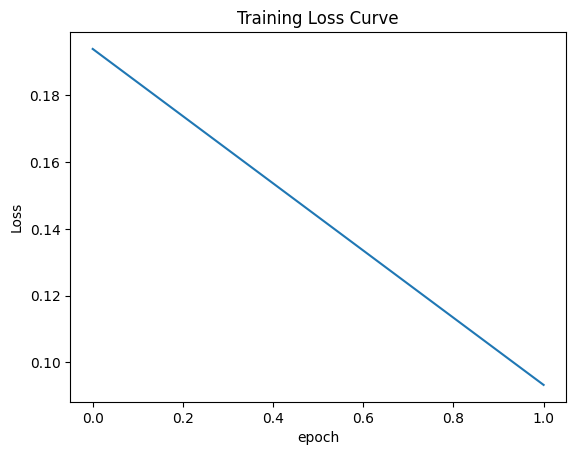

In [108]:
plt.plot(epoch_losses)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

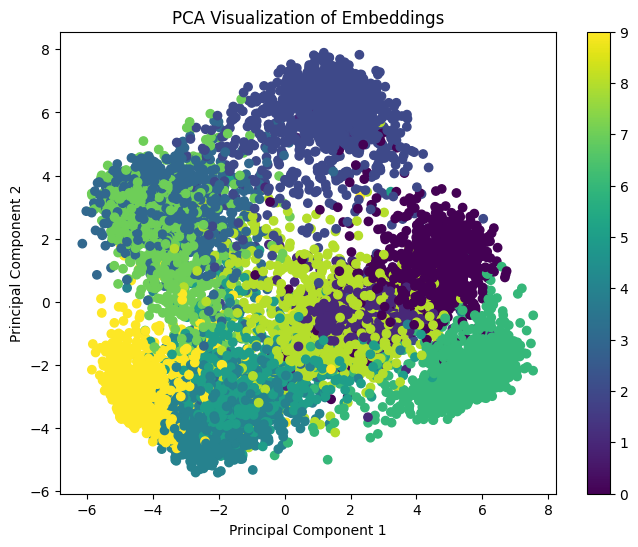

In [131]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch

# Assuming 'model' is your trained EmbeddingNet and 'test_dataset' is your test dataset
test_subset = torch.utils.data.Subset(test_dataset, indices=range(10000))
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=1) # Set batch size to 1 to get individual samples

embeddings = []
labels = []

# Get embeddings for the test subset
with torch.no_grad():
    for data in test_loader:
        image, label = data
        image = image.squeeze(1)
        model.eval()
        # Forward pass through the model
        embedding = model(image)
        embeddings.append(embedding)
        # need to get the item from the label as it is a tensor
        labels.append(label.item())

# Convert the list of embeddings to a tensor
embeddings = torch.cat(embeddings)

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings.detach().numpy())

# Plot the reduced embeddings
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Embeddings')
plt.colorbar()
plt.show()